In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm
from scipy.stats import bootstrap
from scipy.stats import ttest_rel, ttest_1samp
import torch
import os


from matplotlib import font_manager
font_path = '/home/garridoq/fonts/helvetica.ttf' 
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams.update({'font.size': 13})

In [2]:
from pathlib import Path
root = Path("./data_intphys")

# General

In [3]:
from scipy import stats

def hedges_g(data1, data2):
    """
    Calculate Hedge's g for effect size between two groups using raw data.
    Parameters:
    data1 (array-like): data of the first group
    data2 (array-like): data of the second group
    Returns:
    float: Hedge's g
    """
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    sd1 = np.std(data1, ddof=1)  # ddof=1 for sample standard deviation
    sd2 = np.std(data2, ddof=1)
    
    n1 = len(data1)
    n2 = len(data2)
    
    s_pooled = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
    
    # Calculate Cohen's d
    d = (mean1 - mean2) / s_pooled

    correction = 1 - (3 / (4*(n1 + n2) - 9))
    #n= n1+n2
    #correction = ((n-3)/(n-2.25))*np.sqrt((n-2)/n)
    
    # Calculate Hedge's g
    g = d * correction
    
    se = np.sqrt((n1 + n2) / (n1 * n2) + (g**2 / (2 * (n1 + n2))))
    
    # Confidence interval
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    err = z*se
    return g,err

In [4]:
categories = [
        "Object Permanence",
        "Continuity",
        "Shape Constancy",
        "Color Constancy",
        "Support",
        "Inertia",
        "Gravity",
        "Solidity",
        "Collision",
]
mappings = {
    "intphys":{'O1':["Object Permanence"],
               'O2':["Shape Constancy"],
               'O3':["Continuity"]},
    "inflevel":{'continuity':["Object Permanence"],
                'solidity':["Solidity"],
                'gravity':["Gravity"]},
    "grasp":{'Collision':['Collision'],
            'Continuity':['Continuity'],
            'Gravity':['Gravity'],
            'GravityContinuity':['Gravity','Continuity'],
            'GravityInertia':['Gravity','Inertia'],
            'GravityInertia2':['Gravity','Inertia'],
            'GravitySupport':['Gravity','Support'],
            'Inertia':['Inertia'],
            'Inertia2':['Inertia'],
            'ObjectPermanence':['Object Permanence'],
            'ObjectPermanence2':['Object Permanence'],
            'ObjectPermanence3':['Object Permanence'],
            'SolidityContinuity':['Solidity','Continuity'],
            'SolidityContinuity2':['Solidity','Continuity'],
            'Unchangeableness':['Color Constancy'],
            'Unchangeableness2':['Color Constancy']}}

# Main paper

## Figure 1

### Global results

In [5]:
from scipy.stats import norm
from scipy.stats import bootstrap

def plot_hist_g(accs,perfs_rand,labels,title,colors=["#d1ccdc"]+["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10,plot_legend=False,do_bootstrap=False,chance=True):
    labels_cat = ["IntPhys","GRASP","InfLevel-lab"]
    x = np.arange(len(labels_cat))  # the label locations
    width = 0.7/(len(accs)+1)  # the width of the bars
    plt.grid(zorder=1)
    ax=plt.gca()
    start = width*(len(accs)+1)/2-width/2

    rects1 = ax.bar(x-start , perfs_rand.mean(1), width,yerr=perfs_rand.std(1)*1.96,capsize=4, label=labels[0],zorder=2,color=colors[0])
    #plt.scatter((x-start).repeat(perfs_rand.shape[1])+np.random.uniform(-1,1,(len(x)*perfs_rand.shape[1],))*width/7,perfs_rand.flatten(),zorder=10,alpha=0.2,color="#4c4c4c")
        
    for i,acc in enumerate(accs):
        if do_bootstrap:
            yerr_lower = []
            yerr_upper = []
            lengths = [360//2,4096//2,(2268+912+2592)//2]
            for j,acc_ in enumerate(acc):
                syn_preds = np.zeros((lengths[j],))
                syn_preds[:int(acc_/100*lengths[j])] = 1
                b = bootstrap((syn_preds,),np.mean)
                yerr_lower.append(acc_ - b.confidence_interval.low*100)
                yerr_upper.append(b.confidence_interval.high*100 - acc_)
            yerr=[yerr_lower, yerr_upper]
            if i == len(accs) - 1:
                print(np.array(acc) - np.array(yerr_lower))
                print(np.array(acc) + np.array(yerr_upper))
            rects1 = ax.bar(x-start+(i+1)*width , acc, width,yerr=yerr,capsize=4,label=labels[i+1],zorder=2,color=colors[i+1])
        else:
            rects1 = ax.bar(x-start+(i+1)*width , acc, width,label=labels[i+1],zorder=2,color=colors[i+1])
    if chance:
        plt.axhline(50,color="red",linestyle="--",label="Chance level")
    # Show the plot
    ax.set_ylabel('Pairwise classification accuracy (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.xlabel("Dataset")
    plt.title(title)
    plt.ylim([40,None])
    #plt.text(1.5, 45, 'Chance level', color='red', fontsize=12)
    if plot_legend:
        legend=plt.legend(loc="upper right",bbox_to_anchor=(1.01, 1.01))
        legend.get_frame().set_facecolor('white')  
        legend.get_frame().set_alpha(1) 
        legend.get_frame().set_edgecolor('gray')


In [6]:
def get_average_acc(root,exp,dataset,key_metric="Relative Accuracy (avg)"):
    path = root/exp/dataset/"performance.csv"    
    df = pd.read_csv(path,sep=';',skiprows=0)
    props = df["Block"].unique()
    perfs = []
    for prop in props:
        targets = mappings[dataset][prop]
        try:
            acc=df[df["Block"] == prop][key_metric].max()
        except:
            acc=df[df["Block"] == prop].iloc[-1][key_metric]
        
        perfs.append(acc)
    return np.mean(perfs)

In [7]:
key_metric = "Relative Accuracy (avg)"
perfs_rand = []
for dataset in ["intphys","grasp","inflevel"]:
    perfs_per_dataset = []
    perf_by_category = { prop:[] for prop in categories}
    for exp in [f"vit-l-rope-random-{i}" for i in range(20)]:
        perf_by_category_model = get_average_acc(root,exp,dataset,key_metric=key_metric)
        perfs_per_dataset.append(perf_by_category_model)
    perfs_rand.append(perfs_per_dataset)

perfs_methods = []
for dataset in ["intphys","grasp","inflevel"]:
    perfs_per_dataset = []
    perf_by_category = { prop:[] for prop in categories}
    for exp in ["gemini_1.5_pro","qwen2vl_72b","videomaev2_g",f"vit-h-rope-vm2m"]:
        perf = get_average_acc(root,exp,dataset,key_metric=key_metric)
        perfs_per_dataset.append(perf)
    perfs_methods.append(perfs_per_dataset)
        

[95.55555556 64.2578125  59.7020097 ]
[99.44444444 68.39774824 63.2016632 ]


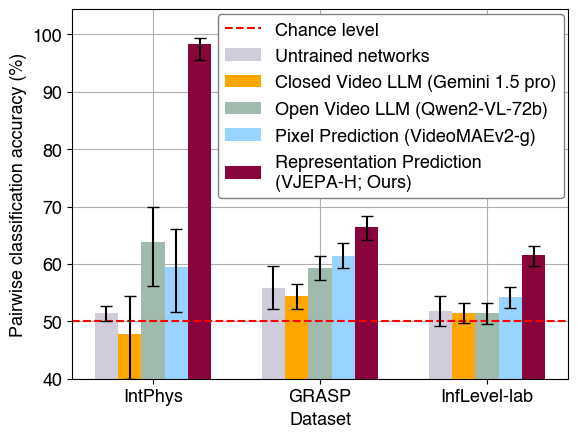

In [8]:
plot_hist_g(np.array(perfs_methods).T,np.array(perfs_rand),
            ["Untrained networks","Closed Video LLM (Gemini 1.5 pro)","Open Video LLM (Qwen2-VL-72b)","Pixel Prediction (VideoMAEv2-g)","Representation Prediction\n(VJEPA-H; Ours)"],
#            ["Untrained networks","Closed Video LLM","Open Video LLM","Pixel Space Prediction","Representation Space Prediction\n(Ours)"],
            "",
            colors=["#d1ccdc","#ffa600","#a0bbad","#99d3ff","#89043d"],
            plot_legend=True,do_bootstrap=True)

plt.savefig("./figures/global_results_1.pdf",bbox_inches="tight")

## Figure 2

### Effect sizes

In [9]:
def get_perf(root,exp,dataset,key_metric="Relative Accuracy (avg)",categories=["Object Permanence","Continuity","Shape Constancy","Color Constancy","Support","Gravity","Solidity","Inertia","Collision",]):
    perf_by_category_model = { prop:[] for prop in categories}
    path = root/exp/dataset/"performance.csv"    
    df = pd.read_csv(path,sep=';',skiprows=0)
    props = df["Block"].unique()
    vals = []
    for prop in props:
        targets = mappings[dataset][prop]
        acc=df[df["Block"] == prop].max()[key_metric]
        for key in targets:
            perf_by_category_model[key].append(acc)
    return perf_by_category_model

In [10]:

key_metric = "Relative Accuracy (avg)"
perfs_rand = []
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in [f"vit-l-rope-random-{i}" for i in range(20)]:
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf_by_category[key].append(np.mean(value))
    perfs_rand.append(perf_by_category)

In [11]:

key_metric = "Relative Accuracy (avg)"
perfs_large = []
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in [f"vit-l-rope-howto-{i}" for i in range(4)]+[f"vit-l-rope-howto"]:
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf_by_category[key].append(np.mean(value))
    perfs_large.append(perf_by_category)

['***', '***', '***']
['**', '*', 'n.s.', '***', '***', '***', 'n.s.', 'n.s.']
['***', 'n.s.', 'n.s.']


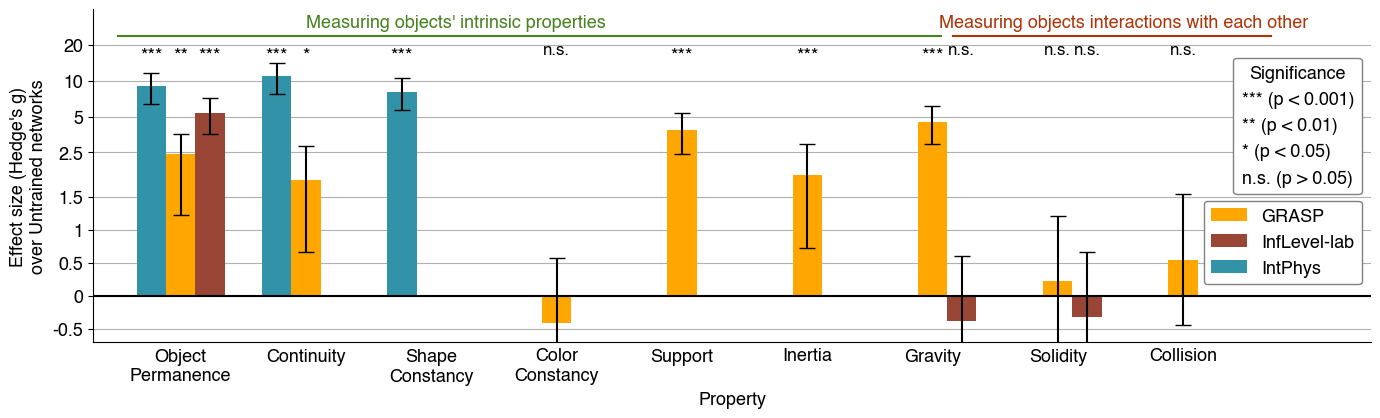

In [12]:
from scipy.stats import ttest_ind
#plt.figure(figsize=(25,5))
plt.figure(figsize=(20*0.7,6*0.7))

colors=["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]

categories_ = [
        "Object\nPermanence",
        "Continuity",
        "Shape\nConstancy",
        "Color\nConstancy",
        "Support",
        "Inertia",
        "Gravity",
        "Solidity",
        "Collision",
]
#Real
labels = ["IntPhys","GRASP","InfLevel-lab"]
labels_cat = categories_
x = np.arange(len(labels_cat))  # the label locations
width = 0.7/len(labels)  # the width of the bars
ax=plt.gca()
start = width*len(labels)/2-width/2
title=""
plot_legend=True
for i,acc in enumerate(perfs_large):
    acc_rand = perfs_rand[i]
    vals = list(acc.values())
    x_plot,y_plot = [],[]
    x_dists,dists = [],[]
    p_s = []
    z_s = []
    errs = []
    for j in range(len(vals)):
        if vals[j] != []:
            x_plot.append(x[j])
            #z_s.append(((np.array(vals[j]) - np.mean(list(perfs_rand[i].values())[j]) )/np.std(list(perfs_rand[i].values())[j])))
            g, err = hedges_g(vals[j],list(perfs_rand[i].values())[j])
            errs.append(err)
            z_s.append(g)
            y_plot.append(np.mean(z_s[-1]))
            x_dists.append([x[j]]*len(vals[j]))
            p_s.append(ttest_ind(list(perfs_rand[i].values())[j],vals[j],alternative="less",equal_var=False).pvalue)
    x_plot,y_plot = np.array(x_plot),np.array(y_plot)
    rects1 = ax.bar(x_plot-start+i*width , y_plot, width,label=labels[i],zorder=2,color=colors[i],yerr=errs,capsize=6)
    #plt.errorbar(x_plot-start+i*width , y_plot,yerr=1.96*np.std(dists,axis=1), color="black", capsize=20, elinewidth=3, markeredgewidth=3,linestyle='')
    #plt.scatter(np.array(x_dists)-start+i*width,z_s,zorder=2,color="k",alpha=0.5,s=15)

    # p values !
    labs = []
    for p in p_s:
        if p < 0.001:
            labs.append("***")
        elif p < 0.01:
            labs.append("**")
        elif p < 0.05:
            labs.append("*")
        else:
            labs.append("n.s.")
        
    print(labs)
    heights = []
    for i,bar in enumerate(rects1):
        heights.append(bar.get_height())
    max_height = np.max(heights)
    for i,bar in enumerate(rects1):
        yval = bar.get_height()
        if labs[i][0] == '*':
            ax.text(bar.get_x() + bar.get_width()/2, 14, labs[i], va='bottom', fontsize=14, fontweight='bold', ha='center')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, 15.9, labs[i], va='bottom', fontsize=12, ha='center')

plt.axhline(0,color="k")


# Show the plot
ax.set_ylabel("Effect size (Hedge's g)\nover Untrained networks")
ax.set_xticks(x)
ax.set_xticklabels(labels_cat,rotation=0,ha="center")
plt.title(title)
plt.ylim([-0.7,40])
plt.yscale('symlog')
def format_func(value, tick_number):
    return f'{value:g}'
# Apply the formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.yticks([-0.5,0,0.5,1,1.5,2.5,5,10,20])


p_labels = ['*** (p < 0.001)', '** (p < 0.01)', '* (p < 0.05)', 'n.s. (p > 0.05)']
p_handles = [plt.Line2D([0], [0], color='w', markerfacecolor='red', markersize=10),
             plt.Line2D([0], [0], color='w', markerfacecolor='orange', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='yellow', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='blue', markersize=10)]
# Add the p-value legend to the plot
p_legend =plt.legend(p_handles, p_labels, title="Significance", frameon=True, handlelength=0, handletextpad=0.1, loc='center right', bbox_to_anchor=(1, 0.65))

# Make chance level lastr
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
legend = plt.legend(handles,labels, loc='center right', bbox_to_anchor=(1, 0.3))
plt.gca().add_artist(p_legend)
plt.tight_layout()
plt.xlim([-0.7,9.5])
legend.set_zorder(30)

#ax.axvspan(-1, 5+width/2, color='#ABE188', alpha=0.3, label='Horizontal Highlight')
plt.text(1,28,"Measuring objects' intrinsic properties",color="#488321",fontweight="bold")
plt.plot([-0.5,6+width/2-0.05],[24,24], color='#488321', linestyle='-', zorder=3)

#ax.axvspan(5+width/2, 10, color='#F78E69', alpha=0.3, label='Horizontal Highlight')
plt.text(6.05,28,"Measuring objects interactions with each other",color="#AE3509",fontweight="bold")
plt.plot([6+width/2+0.05,8.7],[24,24], color='#AE3509', linestyle='-', zorder=3)

#Plot details
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().xaxis.set_tick_params(length=0)

legend.get_frame().set_facecolor('white')  
legend.get_frame().set_alpha(1) 
legend.get_frame().set_edgecolor('gray')

p_legend.get_frame().set_facecolor('white')  
p_legend.get_frame().set_alpha(1) 
p_legend.get_frame().set_edgecolor('gray')

plt.grid(zorder=1,axis="y")
plt.xlabel("Property")

plt.savefig("./figures/hedge_g_per_cat.pdf",bbox_inches="tight")

### Human eval

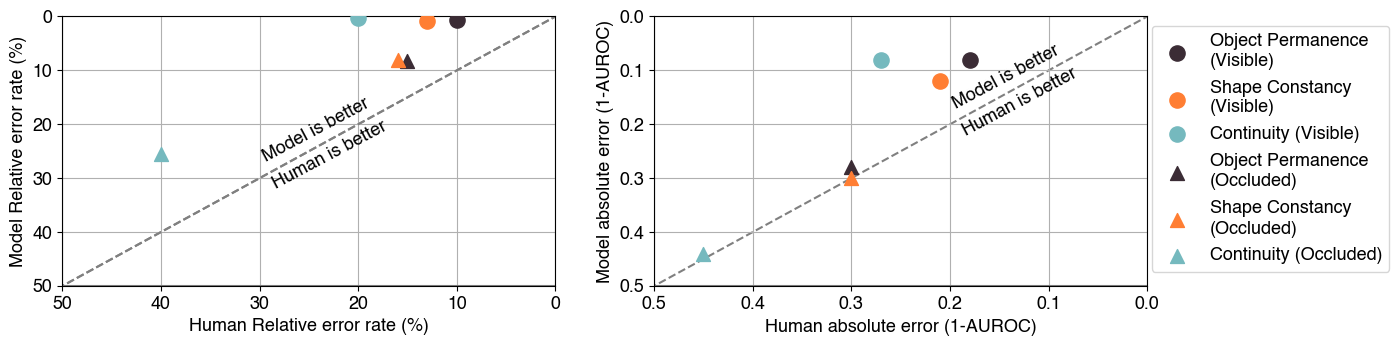

In [13]:
colors = ["#3b2c35","#ff7e33","#75b9be"]
plt.figure(figsize=(20*0.7,5*0.7))

plt.subplot(1,2,1)
human_occluded = np.array([0.15,0.16,0.4])*100
human_visible = np.array([0.1,0.13,0.2])*100

us_avg_occluded = np.array([0.0056,0,0.0019])*100
us_avg_visible = np.array([0,0,0])*100

us_max_occluded = np.array([0.0824,0.0806,0.2556])*100
us_max_visible = np.array([0.0056,0.0083,0.0019])*100
model,human = (us_max_occluded,us_max_visible),(human_occluded,human_visible)
plt.plot([-100,200],[-100,200],linestyle="--",color="gray",zorder=-1)

labels = ["Object Permanence","Shape Constancy","Continuity"]
for i,(m,h) in enumerate(zip(model[1],human[1])):
    if i == 2:
        plt.scatter(h,m,label=labels[i]+" (Visible)",s=120,c=colors[i],zorder=1000)
    else:
        plt.scatter(h,m,label=labels[i]+"\n(Visible)",s=120,c=colors[i],zorder=1000)

for i,(m,h) in enumerate(zip(model[0],human[0])):
    if i ==2:
        plt.scatter(h,m,label=labels[i]+" (Occluded)",s=100,c=colors[i],marker="^",zorder=1000)
    else:
        plt.scatter(h,m,label=labels[i]+"\n(Occluded)",s=100,c=colors[i],marker="^",zorder=1000)
plt.grid()
plt.xlim([-0,50])
plt.ylim([-0,50])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axvline(0.5*100,linestyle="-",color="gray")
plt.axhline(0.5*100,linestyle="-",color="gray")
plt.plot([-100,200],[-100,200],linestyle="--",color="gray")
plt.ylabel("Model Relative error rate (%)")
plt.xlabel("Human Relative error rate (%)")
#plt.text(0.33*100,0.28*100,"Model is better",rotation=45)
#plt.text(0.29*100,0.32*100,"Human is better",rotation=45)

plt.text(0.20*100+10,0.17*100+10,"Model is better",rotation=28)
plt.text(0.19*100+10,0.22*100+10,"Human is better",rotation=28)

#plt.legend(loc='upper center', bbox_to_anchor=(1.25, 0.8), ncol=1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
#plt.legend(loc='lower right')


human_occluded = np.array([0.3,0.3,0.45])
human_visible = np.array([0.18,0.21,0.27])

us_max_occluded = np.array([0.28,0.30,0.44])
us_max_visible = np.array([0.08,0.12,0.08])

plt.subplot(1,2,2)

model,human = (us_max_occluded,us_max_visible),(human_occluded,human_visible)
plt.plot([-100,200],[-100,200],linestyle="--",color="gray",zorder=-1)

labels = ["Object Permanence","Shape Constancy","Continuity"]
for i,(m,h) in enumerate(zip(model[1],human[1])):
    if i == 2:
        plt.scatter(h,m,label=labels[i]+" (Visible)",s=120,c=colors[i],zorder=1000)
    else:
        plt.scatter(h,m,label=labels[i]+"\n(Visible)",s=120,c=colors[i],zorder=1000)

for i,(m,h) in enumerate(zip(model[0],human[0])):
    if i ==2:
        plt.scatter(h,m,label=labels[i]+" (Occluded)",s=100,c=colors[i],marker="^",zorder=1000)
    else:
        plt.scatter(h,m,label=labels[i]+"\n(Occluded)",s=100,c=colors[i],marker="^",zorder=1000)
plt.grid()
plt.xlim([-0.0,0.5])
plt.ylim([-0.0,0.5])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axvline(0.5,linestyle="-",color="gray")
plt.axhline(0.5,linestyle="-",color="gray")
plt.ylabel("Model absolute error (1-AUROC)")
plt.xlabel("Human absolute error (1-AUROC)")
#plt.text(0.33*100,0.28*100,"Model is better",rotation=45)
#plt.text(0.29*100,0.32*100,"Human is better",rotation=45)

plt.text(0.20,0.17,"Model is better",rotation=28)
plt.text(0.19,0.22,"Human is better",rotation=28)

#plt.legend(loc='upper center', bbox_to_anchor=(1.25, 0.8), ncol=1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
#plt.legend(loc='lower right', bbox_to_anchor=(1.1,0))


plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), ncol=1)


plt.savefig("./figures/human_2.pdf",bbox_inches="tight")

## Figure 3

In [14]:
key_metric = "Relative Accuracy (avg)"
perfs_ds = []
for dataset in ["intphys"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in ["vit-l-rope-ssv2",
               "vit-l-rope-k710",
               "vit-l-rope-howto",
               "vit-l-rope-vm2m",]:
        perf = {}
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf[key] = np.mean(value)
        perfs_ds.append(perf)


perfs_vid = []
for dataset in ["intphys"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in ["vit-l-rope-howto-0_1p_vid",
                "vit-l-rope-howto-1p_vid",
                "vit-l-rope-howto-10p_vid",
                "vit-l-rope-howto-25p_vid",
                "vit-l-rope-howto-50p_vid",
                "vit-l-rope-howto",]:
        perf = {}
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf[key] = np.mean(value)
        perfs_vid.append(perf)

perfs_frame = []
for dataset in ["intphys"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in ["vit-l-rope-howto-2p_frame",
                "vit-l-rope-howto-10p_frame",
                "vit-l-rope-howto-25p_frame",
                "vit-l-rope-howto-50p_frame",
                "vit-l-rope-howto",]:
        perf = {}
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf[key] = np.mean(value)
        perfs_frame.append(perf)

perfs_mask = []
for dataset in ["intphys"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in ["vit-l-rope-vm2m",
                "vit-l-rope-vm2m-block_causal",
                "vit-l-rope-vm2m-random_mask",
                "vit-l-rope-vm2m-tube_mask",]:
        perf = {}
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf[key] = np.mean(value)
        perfs_mask.append(perf)

perfs_size = []
for dataset in ["intphys"]:
    perf_by_category = {}
    for exp in ["vit-b-rope-howto",
                "vit-l-rope-howto",
                "vit-h-rope-howto", ]:
        perf = {}
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf[key] = np.mean(value)
        perfs_size.append(perf)


In [15]:
def plot_hist_ablations(accs,labels,title,colors=["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10,plot_legend=False,do_bootstrap=True):
    labels_cat = list(accs[0].keys())
    x = np.arange(len(labels_cat))  # the label locations
    width = 0.7/(len(accs))  # the width of the bars
    plt.grid(zorder=1)
    ax=plt.gca()
    start = width*(len(accs))/2-width/2
    
    for i,acc in enumerate(accs):
        if do_bootstrap:
            yerr_lower = []
            yerr_upper = []
            lengths = [120//2,120//2,120//2]
            for j,acc_ in enumerate(acc.values()):
                syn_preds = np.zeros((lengths[j],))
                syn_preds[:int(acc_/100*lengths[j])] = 1
                b = bootstrap((syn_preds,),np.mean)
                yerr_lower.append(acc_ - b.confidence_interval.low*100)
                yerr_upper.append(b.confidence_interval.high*100 - acc_)
            yerr=[yerr_lower, yerr_upper]
            rects1 = ax.bar(x-start+i*width , acc.values(), width,yerr=yerr,capsize=4,label=labels[i],zorder=2,color=colors[i])
        else:
            rects1 = ax.bar(x-start+i*width , acc.values(), width,label=labels[i],zorder=2,color=colors[i])
    
    #plt.axhline(50,color="red",linestyle="--")
    # Show the plot
    ax.set_ylabel('Pairwise Accuracy on IntPhys (%)')
   # plt.text(x[0]-start, 50.5, 'Chance level', color='red', va='bottom', ha='left')

    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.title(title)
    plt.xlabel("Property")
    plt.ylim([0,None])
    if plot_legend:
        legend = plt.legend(loc='lower right', bbox_to_anchor=(1.015, -0.03))
        legend.get_frame().set_facecolor('white')  
        legend.get_frame().set_alpha(1) 
        legend.get_frame().set_edgecolor('gray')


In [16]:

def plot_size_ablations(accs,percents,title,metric="videos",colors=["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10,plot_legend=True,do_bootstrap=True):

    for i,prop in enumerate(accs[0].keys()):
        vals = [accs[i][prop] for i in range(len(accs))]
        if do_bootstrap:
            yerr_lower = []
            yerr_upper = []
            lengths = [120//2]*len(vals)
            for j,acc_ in enumerate(vals):
                syn_preds = np.zeros((lengths[j],))
                syn_preds[:int(acc_/100*lengths[j])] = 1
                b = bootstrap((syn_preds,),np.mean)
                yerr_lower.append(acc_ - b.confidence_interval.low*100)
                yerr_upper.append(b.confidence_interval.high*100 - acc_)
            yerr=[yerr_lower, yerr_upper]
            #plt.errorbar(percents,vals,yerr=yerr,capsize=4,c="k")
            plt.errorbar(percents,vals,yerr=yerr,capsize=4,marker="o",color=colors[i],label=prop,markersize=7,linewidth=3,elinewidth=2)
        else:
            plt.plot(percents,vals,marker="o",color=colors[i],label=prop,markersize=7,linewidth=3)
    
    plt.grid(True, which="both", ls="--")
    plt.xscale('log')
    plt.title(f"Subsampling {metric} from HowTo100M")
    plt.xlabel(f"Total unique video length")

    plt.ylabel("Pairwise Accuracy on IntPhys (%)")
    
    def format_func(value, tick_number):
        secs_total = 464322717.17889947
        val = value*secs_total/3600/100
        if val < 10000:
            return f'{int(val):g}h'
        elif val < 100000:
            return f'{int(val/24):g}d'
        else:
            return f'{val/24/365:.1f}y'
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
    if 'frames' in metric:
        plt.xticks(percents[:3]+percents[-1:])
    
    plt.ylim([45,101])
    #plt.axhline(50,c="red",linestyle="--",)
    #plt.text(min(percents), 50.5, 'Chance level', color='red', va='bottom', ha='left')
    if plot_legend:
        legend = plt.legend(loc='lower right', bbox_to_anchor=(1.015, -0.03))
        legend.get_frame().set_facecolor('white')  
        legend.get_frame().set_alpha(1) 
        legend.get_frame().set_edgecolor('gray')


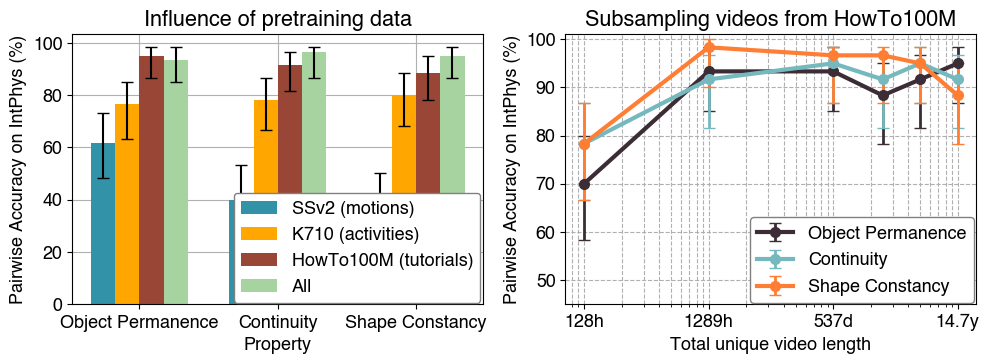

In [18]:
plt.figure(figsize=(25*0.7*2/3,5*0.7))
plt.subplot(1,2,1)
labs = ["SSv2 (motions)","K710 (activities)","HowTo100M (tutorials)","All"]
plot_hist_ablations(perfs_ds,labs,"Influence of pretraining data",plot_legend=True)

plt.subplot(1,2,2)
colors = ["#3b2c35","#75b9be","#ff7e33"]
percents=[0.1,1,10,25,50,100]
plot_size_ablations(perfs_vid,percents,"InTPhys",metric="videos",colors=colors)
plt.savefig("./figures/ablations_vf2_1.pdf",bbox_inches="tight")

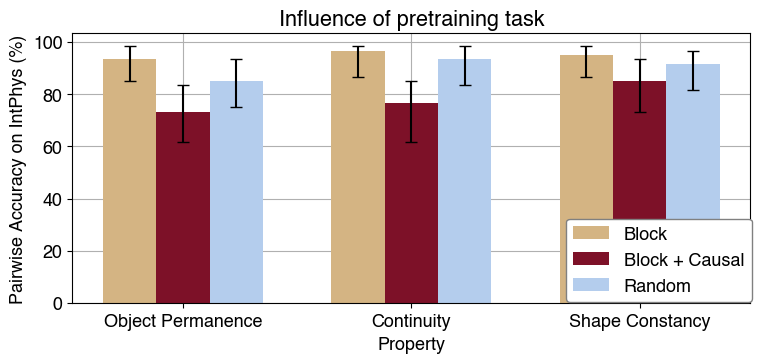

In [19]:
plt.figure(figsize=(25*0.7*1/2,5*0.7))
labs = ["Block","Block + Causal","Random","Tube"]
colors = ["#d4b483","#7d1128","#b4cded","#C44536","#C44536"]
plot_hist_ablations(perfs_mask[:-1],labs[:-1],"Influence of pretraining task",plot_legend=True,colors=colors)

plt.savefig("./figures/ablations_vf2_2.pdf",bbox_inches="tight")

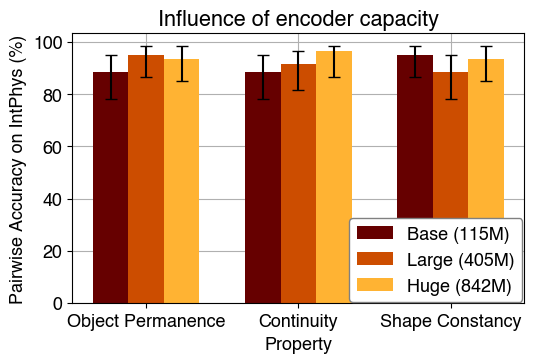

In [20]:
plt.figure(figsize=(25*0.7*1/3,5*0.7))
labs = ["Base (115M)","Large (405M)","Huge (842M)"]
cmap = plt.get_cmap('afmhot')
points = [0.2, 0.4, 0.6]
colors = [cmap(point) for point in points]
plot_hist_ablations(perfs_size,labs,"Influence of encoder capacity",plot_legend=True,colors=colors)
plt.savefig("./figures/ablations_vf2_3.pdf",bbox_inches="tight")

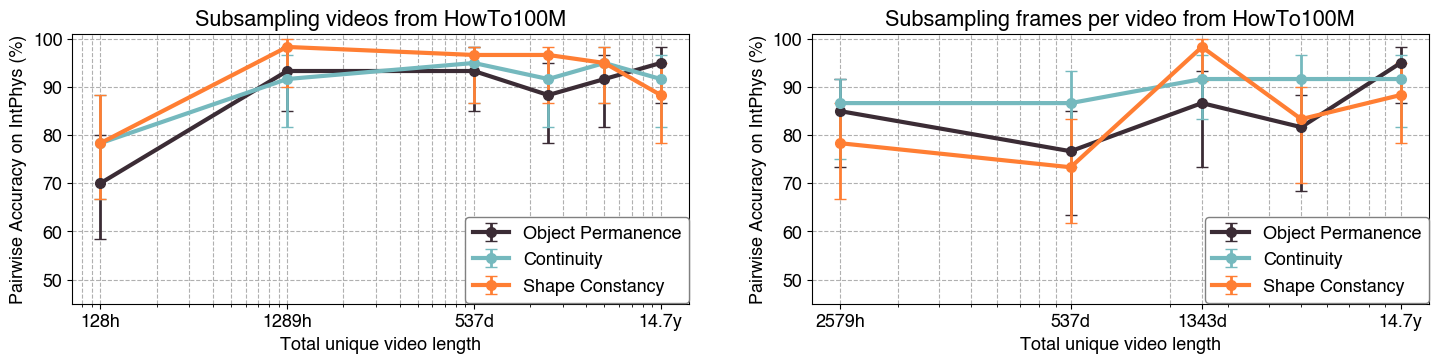

In [21]:
plt.figure(figsize=(25*0.7,5*0.7))
plt.subplot(1,2,1)
colors = ["#3b2c35","#75b9be","#ff7e33"]
percents=[0.1,1,10,25,50,100]
plot_size_ablations(perfs_vid,percents,"InTPhys",metric="videos",colors=colors)
plt.subplot(1,2,2)
percents=[2,10,25,50,100]
plot_size_ablations(perfs_frame,percents,"IntPhys",metric="frames per video",colors=colors)
plt.savefig("./figures/ablations_data.pdf",bbox_inches="tight")

# Supplementary material

## Comparisons context

In [22]:
def get_average_acc_2(root,exp,dataset,key_metric="Relative Accuracy (avg)",idx=0):
    path = root/exp/dataset/"performance.csv"    
    df = pd.read_csv(path,sep=';',skiprows=0)
    props = df["Block"].unique()
    perfs = []
    for prop in props:
        targets = mappings[dataset][prop]
        try:
            acc=df[df["Block"] == prop].iloc[idx][key_metric]
        except:
            acc=df[df["Block"] == prop].iloc[-1][key_metric]
        
        perfs.append(acc)
    return np.mean(perfs)

In [23]:
key_metric = "Relative Accuracy (avg)"
perfs_rand = []
for dataset in ["intphys","grasp","inflevel"]:
    perfs_per_dataset = []
    perf_by_category = { prop:[] for prop in categories}
    for exp in [f"vit-l-rope-random-{i}" for i in range(20)]:
        perf_by_category_model = get_average_acc_2(root,exp,dataset,key_metric=key_metric)
        perfs_per_dataset.append(perf_by_category_model)
    perfs_rand.append(perfs_per_dataset)

perfs_methods = []
for dataset in ["intphys","grasp","inflevel"]:
    perfs_per_dataset = []
    perf_by_category = { prop:[] for prop in categories}
    for exp in ["videomaev2_g",f"vit-l-rope-howto"]:
        perf = get_average_acc(root,exp,dataset,key_metric=key_metric)
        perfs_per_dataset.append(perf)
        perf = get_average_acc_2(root,exp,dataset,key_metric=key_metric)
        perfs_per_dataset.append(perf)
    perfs_methods.append(perfs_per_dataset)
        

[85.55555556 60.59570312 53.84615385]
[94.44444444 64.74609375 57.44975745]


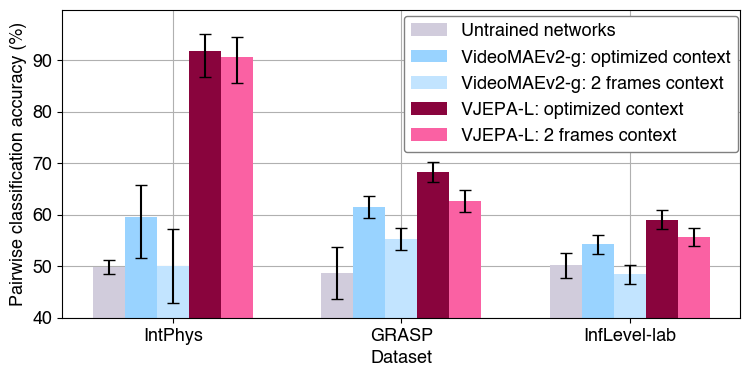

In [24]:
fig =  plt.figure(figsize=(25*0.7/2,5*0.8))

plot_hist_g(np.array(perfs_methods).T,np.array(perfs_rand),
            ["Untrained networks",
             "VideoMAEv2-g: optimized context",
             "VideoMAEv2-g: 2 frames context",
             "VJEPA-L: optimized context",
             "VJEPA-L: 2 frames context"],
            "",
            #colors=["#d1ccdc","#ffa600","#a0bbad","#99d3ff","#89043d"],
            colors=["#d1ccdc","#99d3ff","#C2E4FF","#89043d","#FA61A3"],
            plot_legend=True,do_bootstrap=True,chance=False)

plt.savefig("./figures/ablations_context.pdf",bbox_inches="tight")

In [25]:
from scipy.stats import ttest_ind
import matplotlib
import matplotlib.colors as mcolors

colors=["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]
def plot_all_accuracies_2(perfs_rand,perfs,categories,title="",do_bootstrap=True):
    cmap = matplotlib.colormaps['viridis']
    norm = mcolors.Normalize(vmin=0, vmax=4)

    #Real
    labels = ["IntPhys","GRASP","InfLevel-lab"]
    labels_cat = categories
    x = np.arange(len(labels_cat))  # the label locations
    width = 0.7/len(labels)  # the width of the bars
    plt.grid(zorder=1)
    ax=plt.gca()
    start = width*len(labels)/2-width/2
    plot_legend=True
    for i,acc in enumerate(perfs):
        vals = list(acc.values())
        x_plot,y_plot = [],[]
        x_dists,dists = [],[]
        p_s = []
        # Number of videos for bootstrapping
        if i == 0:
            lengths = [120//2]*3
            
        elif i ==1:
            lengths = [128//2]*8
        elif i == 2:
            lengths = [2268//2,2592//2,912//2]
        m = 0
    
        yerr_lower,yerr_upper = [], []
        for j in range(len(vals)):
            if vals[j] != []:
                x_plot.append(x[j])
                y_plot.append(np.mean(vals[j]))
                dists.append(vals[j])
                x_dists.append([x[j]]*len(vals[j]))
                p_s.append(ttest_ind(list(perfs_rand[i].values())[j],vals[j],alternative="less").pvalue)
                if do_bootstrap:
                    length =  lengths[m]*len(vals[j])
                    syn_preds = np.zeros((length,))
                    syn_preds[:int(np.mean(vals[j])/100*length)] = 1
                    b = bootstrap((syn_preds,),np.mean)
                    #Due to 100% accuracy
                    if str(b.confidence_interval.low) == "nan":
                         yerr_lower.append(0)
                         yerr_upper.append(0)
                    else:
                        yerr_lower.append(np.mean(vals[j]) - b.confidence_interval.low*100)
                        yerr_upper.append(b.confidence_interval.high*100 - np.mean(vals[j]))
                m+=1
        x_plot,y_plot = np.array(x_plot),np.array(y_plot)
        if do_bootstrap:
            yerr=[yerr_lower, yerr_upper]
            #rects1 = ax.bar(x_plot-start+i*width , y_plot, width,label=labels[i],zorder=2,color=colors[i],yerr=yerr,capsize=4)
        else:
            #rects1 = ax.bar(x_plot-start+i*width , y_plot, width,label=labels[i],zorder=2,color=colors[i])
            std  = np.std(dists,axis=1)
            se = std /np.sqrt(len(std))
            #plt.errorbar(x_plot-start+i*width , y_plot,yerr=1.96*se, color=colors[i], capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10,label=labels[i])
            plt.errorbar(x_plot-start+i*width , y_plot,yerr=0, color=colors[i], capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=0,label=labels[i])
            plt.scatter(np.array(x_dists)-start+i*width,dists,zorder=2,c=np.arange(5)[None,...].repeat(len(x_dists),axis=0), cmap=cmap, norm=norm,alpha=0.95,s=50)  
    # Show the plot
    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.title(title)
    plt.ylim([40,105])
    if plot_legend:
        legend=plt.legend(loc="upper right")
        legend.get_frame().set_facecolor('white')  
        legend.get_frame().set_alpha(1) 
        legend.get_frame().set_edgecolor('gray')
        legend.set_zorder(30)

    
    #plt.axhline(50,color="red",linestyle="--",label='Chance level',zorder=10)
    plt.plot([-0.7,10],[50,50],color="red",linestyle="--",label='Chance level',zorder=5)
       
    
    # Show the plot
    ax.set_ylabel('Pairwise accuracy (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.title(title)
    plt.ylim([0,105])
    plt.tight_layout()
    plt.xlim([-0.7,9.5])
    plt.xlabel("Property")



    
    cax = plt.axes((1, 0.07, 0.01, 0.85))
    cbar = plt.colorbar(cax=cax)
    # Set manual labels for the colorbar
    cbar.set_ticks([0,1,2,3,4])
    cbar.set_ticklabels([2,4,6,8,10])
    cbar.set_label('Context length (frames)')
   



In [26]:
def get_perf_2(root,exp,dataset,key_metric="Relative Accuracy (avg)",categories=["Object Permanence","Continuity","Shape Constancy","Color Constancy","Support","Gravity","Solidity","Inertia","Collision",],idx=0):
    perf_by_category_model = { prop:[] for prop in categories}
    path = root/exp/dataset/"performance.csv"    
    df = pd.read_csv(path,sep=';',skiprows=0)
    props = df["Block"].unique()
    vals = []
    for prop in props:
        targets = mappings[dataset][prop]
        acc=df[df["Block"] == prop].iloc[idx][key_metric]

        for key in targets:
            perf_by_category_model[key].append(acc)
    return perf_by_category_model

In [27]:
key_metric = "Relative Accuracy (avg)"
perfs_rand = []
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in [f"vit-l-rope-random-{i}" for i in range(20)]:
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf_by_category[key].append(np.mean(value))
    perfs_rand.append(perf_by_category)

In [28]:

key_metric = "Relative Accuracy (avg)"
perfs_vjepa = []
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = { prop:[] for prop in categories}
    exp = 'vit-l-rope-howto'
    for idx in range(5):
        perf_by_category_model = get_perf_2(root,exp,dataset,key_metric=key_metric,categories=categories,idx=idx)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf_by_category[key].append(np.mean(value))
    perfs_vjepa.append(perf_by_category)

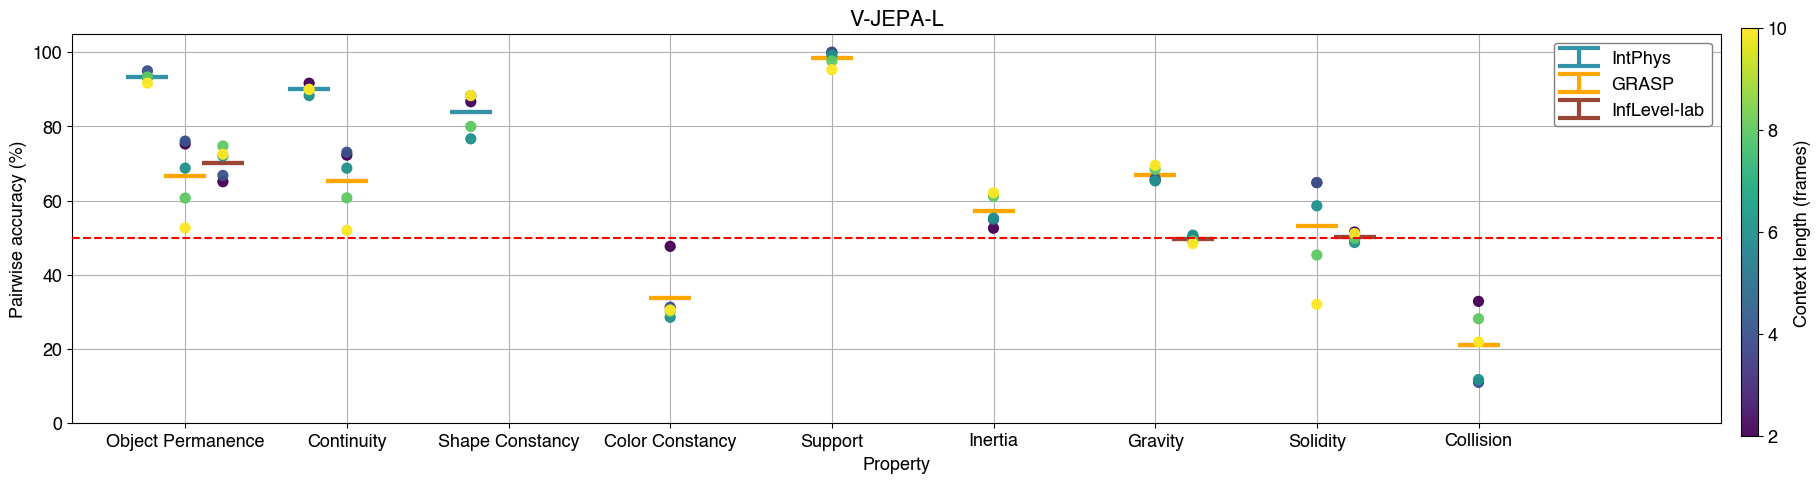

In [29]:
plt.figure(figsize=(25*0.7,6*0.8))
plot_all_accuracies_2(perfs_rand, perfs_vjepa,categories,title="V-JEPA-L",do_bootstrap=False)
plt.savefig("./figures/ablations_context_vjepa.pdf",bbox_inches="tight")

In [30]:

key_metric = "Relative Accuracy (avg)"
perfs_vmae = []
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = { prop:[] for prop in categories}
    exp = 'videomaev2_g'
    for idx in range(5):
        perf_by_category_model = get_perf_2(root,exp,dataset,key_metric=key_metric,categories=categories,idx=idx)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf_by_category[key].append(np.mean(value))
    perfs_vmae.append(perf_by_category)

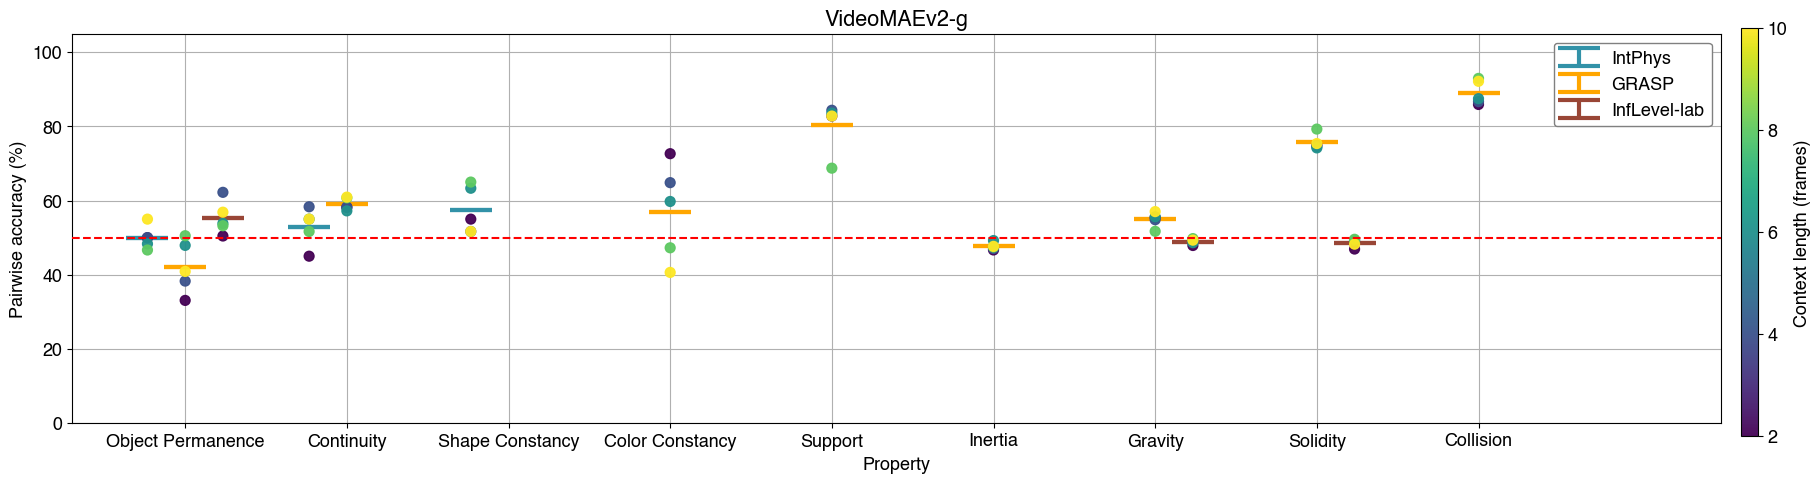

In [31]:
plt.figure(figsize=(25*0.7,6*0.8))
plot_all_accuracies_2(perfs_rand, perfs_vmae,categories,title="VideoMAEv2-g",do_bootstrap=False)
plt.savefig("./figures/ablations_context_videomae.pdf",bbox_inches="tight")

## Max vs Avg Surprise

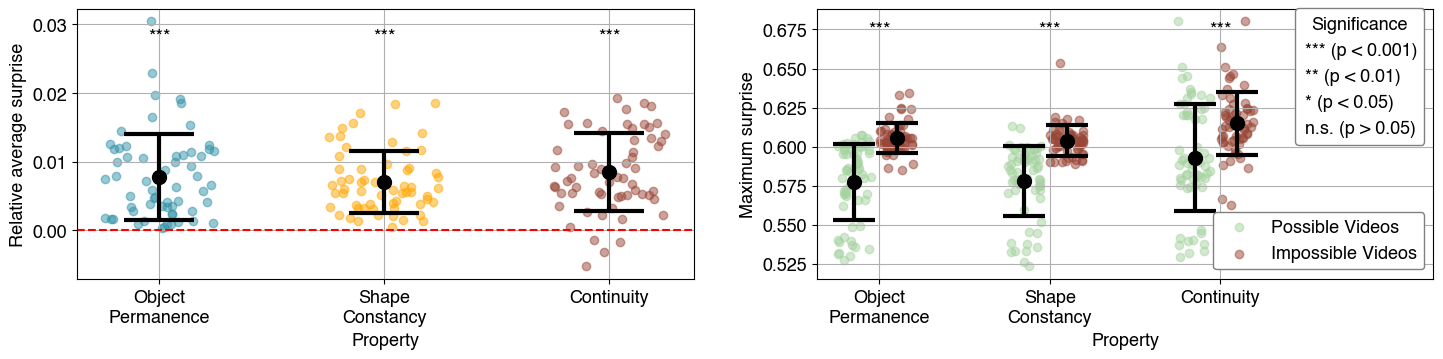

In [32]:
fig =  plt.figure(figsize=(25*0.7,5*0.7))
exp = "vit-h-rope-vm2m"
colors = ["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10
np.random.seed(0)
plt.subplot(1,2,1)
for i,prop in enumerate(["O1","O2","O3"]):
    data = torch.load(root/exp/f"intphys/raw_surprises/{prop}_16frames.pth")
    losses_ = data["losses"]
    labels_ = data["labels"]
    losses = losses_[:,-1] # filtered losses
    diffs = torch.mean(losses[labels_==0] - losses[labels_==1],dim=-1)
    p = ttest_1samp(diffs,0,alternative="greater").pvalue
    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "x"
    
    plt.gca().text(i+0.25, 0.027, label, va='bottom', fontsize=14, fontweight='bold', ha='center')
    
    noise = np.random.uniform(i,i+0.5,(diffs.shape))
    plt.scatter(noise,diffs,alpha=0.5,color=colors[i])
    plt.errorbar(i+0.25, torch.mean(diffs), yerr=torch.std(diffs),color="black", capsize=25,elinewidth=3,capthick=3,fmt="o",markersize=10)

    #plt.gca().text(i+0.25, 0.67, label, va='bottom', fontsize=14, fontweight='bold', ha='center')


plt.grid()
plt.axhline(0,color="red",linestyle="--")
plt.ylabel("Relative average surprise")
ax = plt.gca()
ax.set_xticks([0.25,1.25,2.25])
#plt.axvline(2.75,color="grey",linestyle="--",linewidth=3)
ax.set_xticklabels(['Object\nPermanence', 'Shape\nConstancy', 'Continuity'],rotation=0,ha="center")
plt.xlabel("Property")

plt.subplot(1,2,2)
for i,prop in enumerate(["O1","O2","O3"]):
    data = torch.load(root/exp/f"intphys/raw_surprises/{prop}_16frames.pth")
    losses_ = data["losses"]
    labels_ = data["labels"]
    losses = losses_[:,-1] # filtered losses
    pos = losses[labels_==1].max(dim=1)[0]
    impos = losses[labels_==0].max(dim=1)[0]    
    p=ttest_rel(impos,pos,alternative="greater").pvalue

    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "x"

    plt.gca().text(i+0.25, 0.67, label, va='bottom', fontsize=14, fontweight='bold', ha='center')

    noise = np.random.uniform(i,i+0.20,(pos.shape))
    plt.scatter(noise,pos,alpha=0.5,color=colors[3],label="Possible Videos")
    plt.errorbar(i+0.1, torch.mean(pos), yerr=torch.std(pos),color="black", capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10)
    
    plt.scatter(noise+0.25,impos,alpha=0.5,color=colors[2],label="Impossible Videos")
    plt.errorbar(i+0.35, torch.mean(impos), yerr=torch.std(impos),color="black", capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10)
    #if i == 0:
    #    plt.legend(loc="lower right")

plt.grid()
#plt.axhline(0,color="red",linestyle="--")
plt.ylabel("Maximum surprise")
ax = plt.gca()
ax.set_xticks([0.25,1.25,2.25])
#plt.axvline(2.75,color="grey",linestyle="--",linewidth=3)
ax.set_xticklabels(['Object\nPermanence', 'Shape\nConstancy', 'Continuity'],rotation=0,ha="center")

p_labels = ['*** (p < 0.001)', '** (p < 0.01)', '* (p < 0.05)', 'n.s. (p > 0.05)']
p_handles = [plt.Line2D([0], [0], color='w', markerfacecolor='red', markersize=10),
             plt.Line2D([0], [0], color='w', markerfacecolor='orange', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='yellow', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='blue', markersize=10)]
# Add the p-value legend to the plot
p_legend =plt.legend(p_handles, p_labels, title="Significance", frameon=True, handlelength=0, handletextpad=0.1,loc='center right', bbox_to_anchor=(1, 0.75))

# Make chance level lastr
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
legend = plt.legend(handles,labels, loc='lower right')
plt.gca().add_artist(p_legend)
plt.xlim([None,3.5])
plt.xlabel("Property")

legend.get_frame().set_facecolor('white')  
legend.get_frame().set_alpha(1) 
legend.get_frame().set_edgecolor('gray')

p_legend.get_frame().set_facecolor('white')  
p_legend.get_frame().set_alpha(1) 
p_legend.get_frame().set_edgecolor('gray')

plt.savefig("./figures/surprises.pdf",bbox_inches="tight")

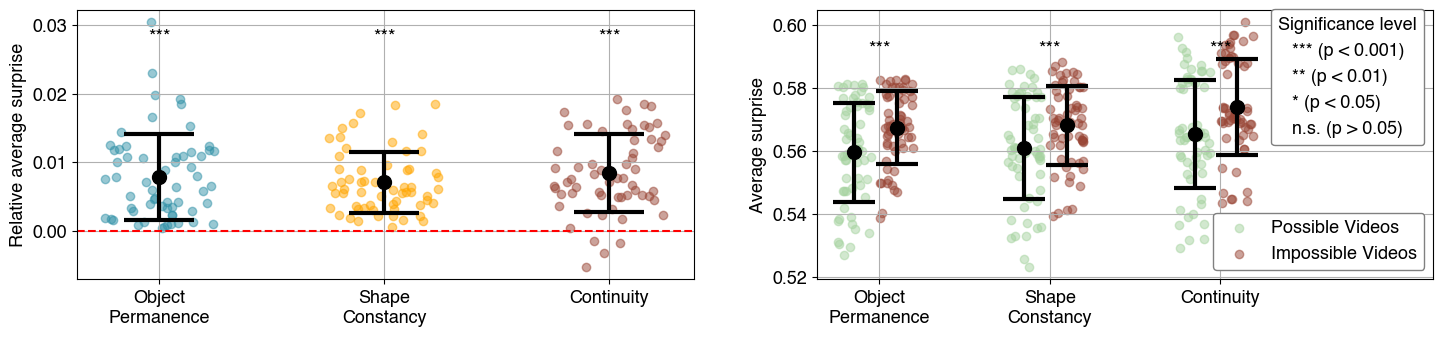

In [33]:
fig =  plt.figure(figsize=(25*0.7,5*0.7))
exp = "vit-h-rope-vm2m"
colors = ["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10
np.random.seed(0)
plt.subplot(1,2,1)
for i,prop in enumerate(["O1","O2","O3"]):
    data = torch.load(root/exp/f"intphys/raw_surprises/{prop}_16frames.pth")
    losses_ = data["losses"]
    labels_ = data["labels"]
    losses = losses_[:,-1] # filtered losses
    diffs = torch.mean(losses[labels_==0] - losses[labels_==1],dim=-1)
    p = ttest_1samp(diffs,0,alternative="greater").pvalue
    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "x"
    
    plt.gca().text(i+0.25, 0.027, label, va='bottom', fontsize=14, fontweight='bold', ha='center')
    
    noise = np.random.uniform(i,i+0.5,(diffs.shape))
    plt.scatter(noise,diffs,alpha=0.5,color=colors[i])
    plt.errorbar(i+0.25, torch.mean(diffs), yerr=torch.std(diffs),color="black", capsize=25,elinewidth=3,capthick=3,fmt="o",markersize=10)

    #plt.gca().text(i+0.25, 0.67, label, va='bottom', fontsize=14, fontweight='bold', ha='center')


plt.grid()
plt.axhline(0,color="red",linestyle="--")
plt.ylabel("Relative average surprise")
ax = plt.gca()
ax.set_xticks([0.25,1.25,2.25])
#plt.axvline(2.75,color="grey",linestyle="--",linewidth=3)
ax.set_xticklabels(['Object\nPermanence', 'Shape\nConstancy', 'Continuity'],rotation=0,ha="center")


plt.subplot(1,2,2)
for i,prop in enumerate(["O1","O2","O3"]):
    data = torch.load(root/exp/f"intphys/raw_surprises/{prop}_16frames.pth")
    losses_ = data["losses"]
    labels_ = data["labels"]
    losses = losses_[:,-1] # filtered losses
    pos = losses[labels_==1].mean(dim=1)
    impos = losses[labels_==0].mean(dim=1)
    p=ttest_rel(impos,pos,alternative="greater").pvalue

    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "x"

    plt.gca().text(i+0.25, 0.59, label, va='bottom', fontsize=14, fontweight='bold', ha='center')

    noise = np.random.uniform(i,i+0.20,(pos.shape))
    plt.scatter(noise,pos,alpha=0.5,color=colors[3],label="Possible Videos")
    plt.errorbar(i+0.1, torch.mean(pos), yerr=torch.std(pos),color="black", capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10)
    
    plt.scatter(noise+0.25,impos,alpha=0.5,color=colors[2],label="Impossible Videos")
    plt.errorbar(i+0.35, torch.mean(impos), yerr=torch.std(impos),color="black", capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10)
    #if i == 0:
    #    plt.legend(loc="lower right")

plt.grid()
#plt.axhline(0,color="red",linestyle="--")
plt.ylabel("Average surprise")
ax = plt.gca()
ax.set_xticks([0.25,1.25,2.25])
#plt.axvline(2.75,color="grey",linestyle="--",linewidth=3)
ax.set_xticklabels(['Object\nPermanence', 'Shape\nConstancy', 'Continuity'],rotation=0,ha="center")

p_labels = ['*** (p < 0.001)', '** (p < 0.01)', '* (p < 0.05)', 'n.s. (p > 0.05)']
p_handles = [plt.Line2D([0], [0], color='w', markerfacecolor='red', markersize=10),
             plt.Line2D([0], [0], color='w', markerfacecolor='orange', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='yellow', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='blue', markersize=10)]
# Add the p-value legend to the plot
p_legend =plt.legend(p_handles, p_labels, title="Significance level", frameon=True, handlelength=0, handletextpad=0.1,loc='center right', bbox_to_anchor=(1, 0.75))

# Make chance level lastr
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
legend = plt.legend(handles,labels, loc='lower right')
plt.gca().add_artist(p_legend)
plt.xlim([None,3.5])

legend.get_frame().set_facecolor('white')  
legend.get_frame().set_alpha(1) 
legend.get_frame().set_edgecolor('gray')

p_legend.get_frame().set_facecolor('white')  
p_legend.get_frame().set_alpha(1) 
p_legend.get_frame().set_edgecolor('gray')


plt.savefig("./figures/avg_surprises.pdf",bbox_inches="tight")

/tmp/ipykernel_2260395/536169521.py:105: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Helvetica.
  plt.savefig("./figures/max_surprises.pdf",bbox_inches="tight")
/tmp/ipykernel_2260395/536169521.py:105: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Helvetica.
  plt.savefig("./figures/max_surprises.pdf",bbox_inches="tight")
/home/garridoq/.conda/envs/video/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Helvetica.
  fig.canvas.print_figure(bytes_io, **kw)


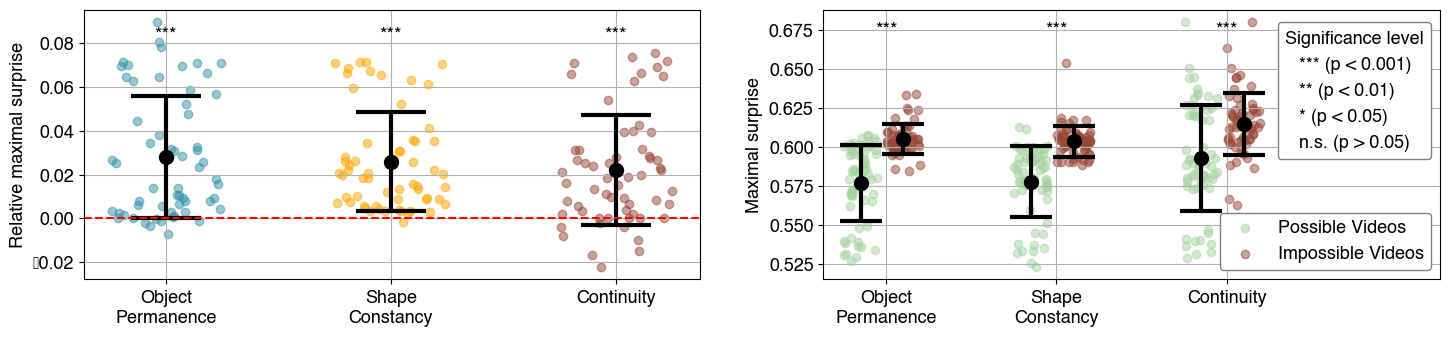

In [34]:
fig =  plt.figure(figsize=(25*0.7,5*0.7))
exp = "vit-h-rope-vm2m"
colors = ["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10
np.random.seed(0)
plt.subplot(1,2,1)
for i,prop in enumerate(["O1","O2","O3"]):
    data = torch.load(root/exp/f"intphys/raw_surprises/{prop}_16frames.pth")
    losses_ = data["losses"]
    labels_ = data["labels"]
    losses = losses_[:,-1] # filtered losses
    pos = losses[labels_==1].max(dim=1)[0]
    impos = losses[labels_==0].max(dim=1)[0] 
    diffs = impos-pos
    p = ttest_1samp(diffs,0,alternative="greater").pvalue
    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "x"
    
    plt.gca().text(i+0.25, 0.08, label, va='bottom', fontsize=14, fontweight='bold', ha='center')
    
    noise = np.random.uniform(i,i+0.5,(diffs.shape))
    plt.scatter(noise,diffs,alpha=0.5,color=colors[i])
    plt.errorbar(i+0.25, torch.mean(diffs), yerr=torch.std(diffs),color="black", capsize=25,elinewidth=3,capthick=3,fmt="o",markersize=10)

    #plt.gca().text(i+0.25, 0.67, label, va='bottom', fontsize=14, fontweight='bold', ha='center')


plt.grid()
plt.axhline(0,color="red",linestyle="--")
plt.ylabel("Relative maximal surprise")
ax = plt.gca()
ax.set_xticks([0.25,1.25,2.25])
#plt.axvline(2.75,color="grey",linestyle="--",linewidth=3)
ax.set_xticklabels(['Object\nPermanence', 'Shape\nConstancy', 'Continuity'],rotation=0,ha="center")


plt.subplot(1,2,2)
for i,prop in enumerate(["O1","O2","O3"]):
    data = torch.load(root/exp/f"intphys/raw_surprises/{prop}_16frames.pth")
    losses_ = data["losses"]
    labels_ = data["labels"]
    losses = losses_[:,-1] # filtered losses
    pos = losses[labels_==1].max(dim=1)[0]
    impos = losses[labels_==0].max(dim=1)[0]    
    p=ttest_rel(impos,pos,alternative="greater").pvalue

    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "x"

    plt.gca().text(i+0.25, 0.67, label, va='bottom', fontsize=14, fontweight='bold', ha='center')

    noise = np.random.uniform(i,i+0.20,(pos.shape))
    plt.scatter(noise,pos,alpha=0.5,color=colors[3],label="Possible Videos")
    plt.errorbar(i+0.1, torch.mean(pos), yerr=torch.std(pos),color="black", capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10)
    
    plt.scatter(noise+0.25,impos,alpha=0.5,color=colors[2],label="Impossible Videos")
    plt.errorbar(i+0.35, torch.mean(impos), yerr=torch.std(impos),color="black", capsize=15,elinewidth=3,capthick=3,fmt="o",markersize=10)
    #if i == 0:
    #    plt.legend(loc="lower right")

plt.grid()
#plt.axhline(0,color="red",linestyle="--")
ax = plt.gca()
ax.set_xticks([0.25,1.25,2.25])
#plt.axvline(2.75,color="grey",linestyle="--",linewidth=3)
ax.set_xticklabels(['Object\nPermanence', 'Shape\nConstancy', 'Continuity'],rotation=0,ha="center")
plt.ylabel("Maximal surprise")

p_labels = ['*** (p < 0.001)', '** (p < 0.01)', '* (p < 0.05)', 'n.s. (p > 0.05)']
p_handles = [plt.Line2D([0], [0], color='w', markerfacecolor='red', markersize=10),
             plt.Line2D([0], [0], color='w', markerfacecolor='orange', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='yellow', markersize=10),
             plt.Line2D([0], [0],  color='w', markerfacecolor='blue', markersize=10)]
# Add the p-value legend to the plot
p_legend =plt.legend(p_handles, p_labels, title="Significance level", frameon=True, handlelength=0, handletextpad=0.1,loc='center right', bbox_to_anchor=(1, 0.7))

# Make chance level lastr
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:2]
labels = labels[:2]
legend = plt.legend(handles,labels, loc='lower right')
plt.gca().add_artist(p_legend)
plt.xlim([None,3.5])

legend.get_frame().set_facecolor('white')  
legend.get_frame().set_alpha(1) 
legend.get_frame().set_edgecolor('gray')

p_legend.get_frame().set_facecolor('white')  
p_legend.get_frame().set_alpha(1) 
p_legend.get_frame().set_edgecolor('gray')


plt.savefig("./figures/max_surprises.pdf",bbox_inches="tight")

## Relabeled inflevel

In [35]:
def plot_hist_g2(accs,perfs_rand,labels,title,labels_cat=["IntPhys","GRASP","InfLevel-lab"],colors=["#d1ccdc"]+["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]*10,plot_legend=False,do_bootstrap=False):    
    x = np.arange(len(labels_cat))  # the label locations
    width = 0.7/(len(accs)+1)  # the width of the bars
    plt.grid(zorder=1)
    ax=plt.gca()
    start = width*(len(accs)+1)/2-width/2

    rects1 = ax.bar(x-start , perfs_rand.mean(1), width,yerr=perfs_rand.std(1)*1.96,capsize=4, label=labels[0],zorder=2,color=colors[0])
    #plt.scatter((x-start).repeat(perfs_rand.shape[1])+np.random.uniform(-1,1,(len(x)*perfs_rand.shape[1],))*width/7,perfs_rand.flatten(),zorder=10,alpha=0.2,color="#4c4c4c")
        
    for i,acc in enumerate(accs):
        if do_bootstrap:
            yerr_lower = []
            yerr_upper = []
            lengths = [2268//2,912//2,2592//2]
            for j,acc_ in enumerate(acc):
                syn_preds = np.zeros((lengths[j],))
                syn_preds[:int(acc_/100*lengths[j])] = 1
                b = bootstrap((syn_preds,),np.mean)
                yerr_lower.append(acc_ - b.confidence_interval.low*100)
                yerr_upper.append(b.confidence_interval.high*100 - acc_)
            yerr=[yerr_lower, yerr_upper]
            rects1 = ax.bar(x-start+(i+1)*width , acc, width,yerr=yerr,capsize=4,label=labels[i+1],zorder=2,color=colors[i+1])
        else:
            rects1 = ax.bar(x-start+(i+1)*width , acc, width,label=labels[i+1],zorder=2,color=colors[i+1])
    plt.axhline(50,color="red",linestyle="--",label="Chance level")
    # Show the plot
    ax.set_ylabel('Pairwise classification accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.title(title)
    plt.ylim([40,None])
    #plt.text(1.5, 45, 'Chance level', color='red', fontsize=12)
    if plot_legend:
        legend=plt.legend(loc="lower right")
        legend.get_frame().set_facecolor('white')  
        legend.get_frame().set_alpha(1) 
        legend.get_frame().set_edgecolor('gray')



In [36]:
def get_average_acc(root,exp,dataset,key_metric="Relative Accuracy (avg)"):
    path = root/exp/dataset/"performance.csv"    
    df = pd.read_csv(path,sep=';',skiprows=0)
    props = df["Block"].unique()
    perfs = []
    for prop in props:
        targets = mappings[dataset][prop]
        acc=df[df["Block"] == prop].max()[key_metric]
        perfs.append(acc)
    return np.mean(perfs)

def get_relabeled_acc_inflevel(path,prop,log=False):
    if not "mae" in str(path):
        losses  = torch.load(path / f"raw_surprises/{prop}_32frames.pth")['losses']
    else:
        losses  = torch.load(path / f"raw_surprises/{prop}_16frames.pth")['losses']

    mask = []
    df = pd.read_csv(f"/home/garridoq/rsc/datasets/{prop}.csv")
    labels = []
    for row in df.itertuples():
        if 'ci.mp4' in row.vid1_path or 'cv.mp4' in row.vid1_path:
            mask.append(False)
        else:
            mask.append(True)
        
    for ctx_idx in [4]:
        avg = losses[:,ctx_idx].mean(1)
        vals = avg.reshape(8,-1,2).transpose(0, 1).reshape(-1,2)
        labels = torch.Tensor([0,1]).repeat(vals.shape[0]).reshape(*vals.shape)
        y = labels[:len(mask)][mask,:]
        x = vals[:len(mask)][mask,:]
        acc = ((x.argmax(dim=1) == y.argmax(dim=1)).sum()/len(y)).item()*100
        if log:
            print(f"Acc: {acc:.2f}")
    return acc

dataset = "inflevel"
key_metric = "Relative Accuracy (avg)"

perfs_rand_easy = []
perfs_rand = []
for exp in [f"vit-l-rope-random-{i}" for i in range(20)]:
    perf_easy = []
    acc = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
    acc = [acc["Object Permanence"][0],acc["Solidity"][0],acc["Gravity"][0]]
    perfs_rand.append(acc)
    perfs_rand_easy_ = []
    for prop in ["continuity","solidity","gravity"]:
        acc = get_relabeled_acc_inflevel(root/exp/dataset,prop)
        perfs_rand_easy_.append(acc)
    perfs_rand_easy.append(perfs_rand_easy_)

perfs_per_category = []
perfs_per_category_easy = []
for exp in [ "vit-l-rope-howto","videomaev2_g",]:
    perf_easy = []
    acc = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
    acc = [acc["Object Permanence"][0],acc["Solidity"][0],acc["Gravity"][0]]
    perfs_per_category.append(acc)
    for prop in ["continuity","solidity","gravity"]:
        acc = get_relabeled_acc_inflevel(root/exp/dataset,prop)
        perf_easy.append(acc)
    perfs_per_category_easy.append(perf_easy)

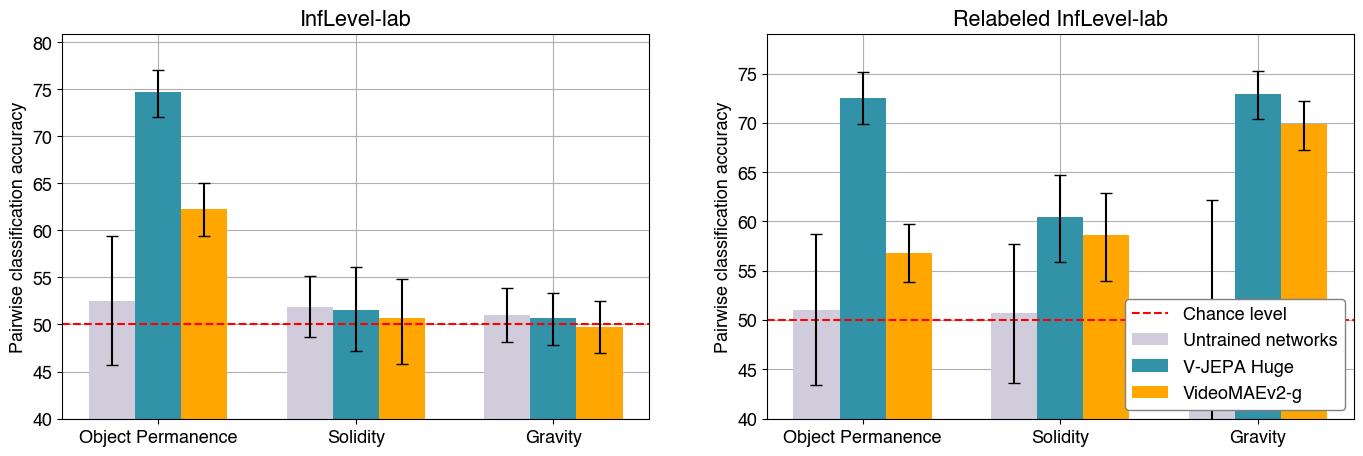

In [37]:

plt.figure(figsize=(25*2/3.,5))
labs = ["V-JEPA Huge","VideoMAEv2-g"]

plt.subplot(1,2,1)
plot_hist_g2(np.array(perfs_per_category),np.array(perfs_rand).T,
             ["Untrained networks"]+labs,"InfLevel-lab",labels_cat=["Object Permanence","Solidity","Gravity"],plot_legend=False,do_bootstrap=True)

plt.subplot(1,2,2)
plot_hist_g2(np.array(perfs_per_category_easy),np.array(perfs_rand_easy).T,
             ["Untrained networks"]+labs,"Relabeled InfLevel-lab",labels_cat=["Object Permanence","Solidity","Gravity"],plot_legend=True,do_bootstrap=True)
plt.savefig("./figures/relabeld_inflevel.pdf",bbox_inches="tight")


## Probabilities Qwen

In [38]:


def plot_hist_llm(root,dataset,legend=False,title="",full_x=False):
    
    probs_impossible = []
    probs_possible = []
    
    root_surprises = root / f"qwen2vl_72b/{dataset}/raw_surprises/"
    for prop in os.listdir(root_surprises):
        preds = torch.load(root_surprises/prop)
        labels = preds["labels"]
        proba = preds["vid_1_proba"]
        
        for i in range(len(labels)):
            if labels[i][0] == 1:
                probs_possible.append(1-proba[i])
                probs_impossible.append(proba[i])
            else:
                probs_impossible.append(1-proba[i])
                probs_possible.append(proba[i])
    
    plt.hist(probs_impossible,label="Impossible videos",alpha=0.7,density=True,color="#BF1A2F")
    plt.hist(probs_possible,label="Possible videos",alpha=0.8,density=True,color="#4D9DE0")
    plt.xlabel("Probability of being possible")
    plt.ylabel("Density")
    plt.grid()
    if legend:
        legend=plt.legend()
        legend.get_frame().set_facecolor('white')  
        legend.get_frame().set_alpha(1) 
        legend.get_frame().set_edgecolor('gray')
    if full_x:
        plt.xlim([0,1])
    plt.title(title)

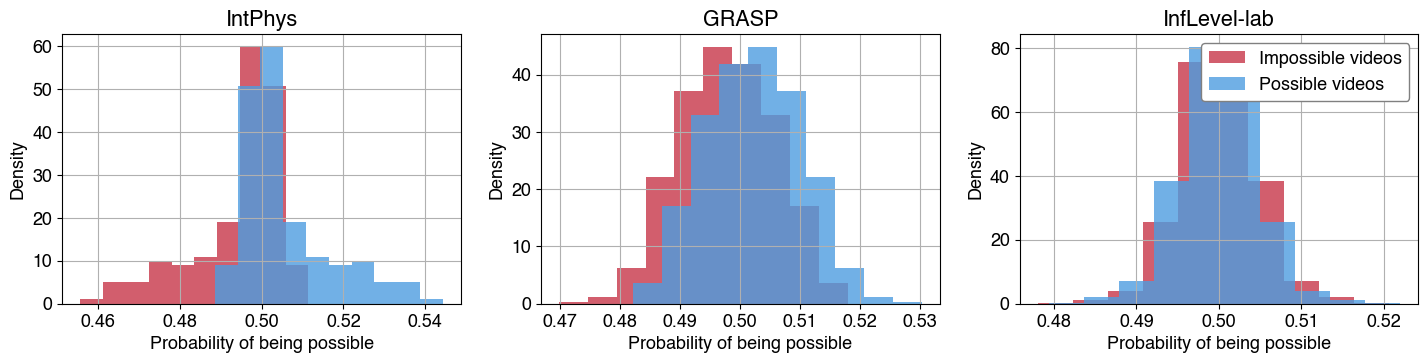

In [39]:
plt.figure(figsize=(25*0.7,5*0.7))
plt.subplot(1,3,1)
plot_hist_llm(root,"intphys",title="IntPhys")

plt.subplot(1,3,2)
plot_hist_llm(root,"grasp",title="GRASP")

plt.subplot(1,3,3)
plot_hist_llm(root,"inflevel",title="InfLevel-lab",legend=True)

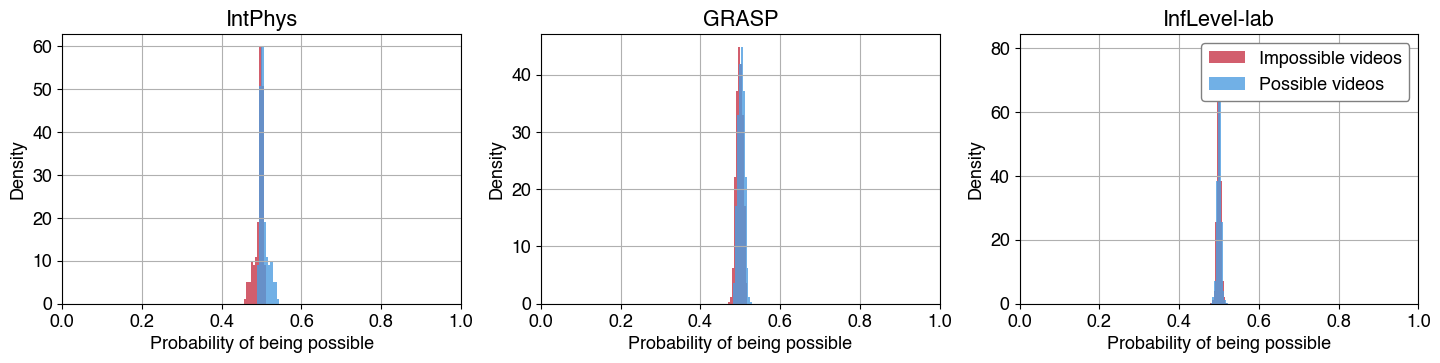

In [40]:
plt.figure(figsize=(25*0.7,5*0.7))
plt.subplot(1,3,1)
plot_hist_llm(root,"intphys",title="IntPhys",full_x=True)

plt.subplot(1,3,2)
plot_hist_llm(root,"grasp",title="GRASP",full_x=True)

plt.subplot(1,3,3)
plot_hist_llm(root,"inflevel",title="InfLevel-lab",legend=True,full_x=True)
plt.savefig("./figures/probas_qwen.pdf",bbox_inches="tight")

## Accuracy for all methods

In [41]:
from scipy.stats import ttest_ind
colors=["#3292a8","#ffa600","#994636","#a6d3a0","#d4b483","#7d1128","#b4cded","#b279a7","#bfcc94"]

def plot_all_accuracies(perfs_rand,perfs,categories,title="",do_bootstrap=True):

    #Real
    labels = ["IntPhys","GRASP","InfLevel-lab"]
    labels_cat = categories
    x = np.arange(len(labels_cat))  # the label locations
    width = 0.7/len(labels)  # the width of the bars
    plt.grid(zorder=1)
    ax=plt.gca()
    start = width*len(labels)/2-width/2
    plot_legend=True
    for i,acc in enumerate(perfs):
        vals = list(acc.values())
        x_plot,y_plot = [],[]
        x_dists,dists = [],[]
        p_s = []
        # Number of videos for bootstrapping
        if i == 0:
            lengths = [120//2]*3
        elif i ==1:
            lengths = [128//2]*8
        elif i == 2:
            lengths = [2268//2,2592//2,912//2]
        m = 0
    
        yerr_lower,yerr_upper = [], []
        for j in range(len(vals)):
            if vals[j] != []:
                x_plot.append(x[j])
                y_plot.append(np.mean(vals[j]))
                dists.append(vals[j])
                x_dists.append([x[j]]*len(vals[j]))
                p_s.append(ttest_ind(list(perfs_rand[i].values())[j],vals[j],alternative="less").pvalue)
                if do_bootstrap:
                    length =  lengths[m]*len(vals[j])
                    syn_preds = np.zeros((length,))
                    syn_preds[:int(np.mean(vals[j])/100*length)] = 1
                    b = bootstrap((syn_preds,),np.mean)
                    #Due to 100% accuracy
                    if str(b.confidence_interval.low) == "nan":
                         yerr_lower.append(0)
                         yerr_upper.append(0)
                    else:
                        yerr_lower.append(np.mean(vals[j]) - b.confidence_interval.low*100)
                        yerr_upper.append(b.confidence_interval.high*100 - np.mean(vals[j]))
                m+=1
        x_plot,y_plot = np.array(x_plot),np.array(y_plot)
        if do_bootstrap:
            yerr=[yerr_lower, yerr_upper]
            rects1 = ax.bar(x_plot-start+i*width , y_plot, width,label=labels[i],zorder=2,color=colors[i],yerr=yerr,capsize=4)
        else:
            rects1 = ax.bar(x_plot-start+i*width , y_plot, width,label=labels[i],zorder=2,color=colors[i])
            std  = np.std(dists,axis=1)
            se = std /np.sqrt(len(std))
            plt.errorbar(x_plot-start+i*width , y_plot,yerr=1.96*se, color="black", capsize=4,linestyle='')
            plt.scatter(np.array(x_dists)-start+i*width,dists,zorder=2,color="#1c1c1c",alpha=0.8)
    
        # p values !
        labs = []
        for p in p_s:
            if p < 0.001:
                labs.append("***")
            elif p < 0.01:
                labs.append("**")
            elif p < 0.05:
                labs.append("*")
            else:
                labs.append("n.s.")
            
        heights = []
        for i,bar in enumerate(rects1):
            heights.append(bar.get_height())
        max_height = np.max(heights)
        for i,bar in enumerate(rects1):
            if labs[i][0] == '*':
                ax.text(bar.get_x() + bar.get_width()/2, 100, labs[i], va='bottom', fontsize=12, fontweight='bold', ha='center')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, 101, labs[i], va='bottom', fontsize=10, ha='center')
     
    # Show the plot
    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.title(title)
    plt.ylim([40,105])
    if plot_legend:
        plt.legend(loc="upper right")
    
    # Random
    labels = ["intphys","grasp","inflevel"]
    labels_cat = categories
    x = np.arange(len(labels_cat))  # the label locations
    width = 0.7/len(labels)  # the width of the bars
    plt.grid(zorder=1)
    ax=plt.gca()
    start = width*len(labels)/2-width/2
    plot_legend=True
    for i,acc in enumerate(perfs_rand):
        vals = list(acc.values())
        x_plot,y_plot = [],[]
        x_dists,dists = [],[]
        for j in range(len(vals)):
            if vals[j] != []:
                x_plot.append(x[j])
                y_plot.append(np.mean(vals[j]))
                dists.append(vals[j])
                x_dists.append([x[j]]*len(vals[j]))
        x_plot,y_plot = np.array(x_plot),np.array(y_plot)
        rects1 = ax.bar(x_plot-start+i*width , y_plot, width,zorder=2,color="grey",alpha=0.4,label="Untrained networks" if i==0 else None)
        #plt.errorbar(x_plot-start+i*width , y_plot,yerr=1.96*np.std(dists,axis=1), color="black", capsize=20, elinewidth=3, markeredgewidth=3,linestyle='')
    
        for bar in rects1:
            bar.set_hatch('//')
            bar.set_edgecolor('black')
        plt.scatter(np.array(x_dists)-start+i*width+width/8,dists,zorder=2,color="grey",alpha=0.5)
    
    #plt.axhline(50,color="red",linestyle="--",label='Chance level',zorder=10)
    plt.plot([-0.7,10],[50,50],color="red",linestyle="--",label='Chance level',zorder=5)
       
    
    # Show the plot
    ax.set_ylabel('Pairwise accuracy (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_cat,rotation=0,ha="center")
    plt.title(title)
    plt.ylim([0,105])
    
    p_labels = ['*** (p < 0.001)', '** (p < 0.01)', '* (p < 0.05)', 'n.s. (p > 0.05)']
    p_handles = [plt.Line2D([0], [0], color='w', markerfacecolor='red', markersize=10),
                 plt.Line2D([0], [0], color='w', markerfacecolor='orange', markersize=10),
                 plt.Line2D([0], [0],  color='w', markerfacecolor='yellow', markersize=10),
                 plt.Line2D([0], [0],  color='w', markerfacecolor='blue', markersize=10)]
    # Add the p-value legend to the plot
    p_legend =plt.legend(p_handles, p_labels, title="Significance", frameon=True, handlelength=0, handletextpad=0.5, loc='center right', bbox_to_anchor=(1, 0.75),)
    
    # Make chance level lastr
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[1:] + [handles[0]]
    labels = labels[1:] + [labels[0]]
    legend = plt.legend(handles,labels, loc='center right', bbox_to_anchor=(1, 0.2))
    plt.gca().add_artist(p_legend)
    plt.tight_layout()
    plt.xlim([-0.7,9.5])
    legend.set_zorder(30)
    legend.get_frame().set_facecolor('white')  
    legend.get_frame().set_alpha(1) 
    legend.get_frame().set_edgecolor('gray')

    p_legend.get_frame().set_facecolor('white')  
    p_legend.get_frame().set_alpha(1) 
    p_legend.get_frame().set_edgecolor('gray')
    plt.xlabel("Property")

key_metric = "Relative Accuracy (avg)"
perfs_rand = []
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = { prop:[] for prop in categories}
    for exp in [f"vit-l-rope-random-{i}" for i in range(20)]:
        perf_by_category_model = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
        for key,value in perf_by_category_model.items():
            if value != []:
                perf_by_category[key].append(np.mean(value))
    perfs_rand.append(perf_by_category)

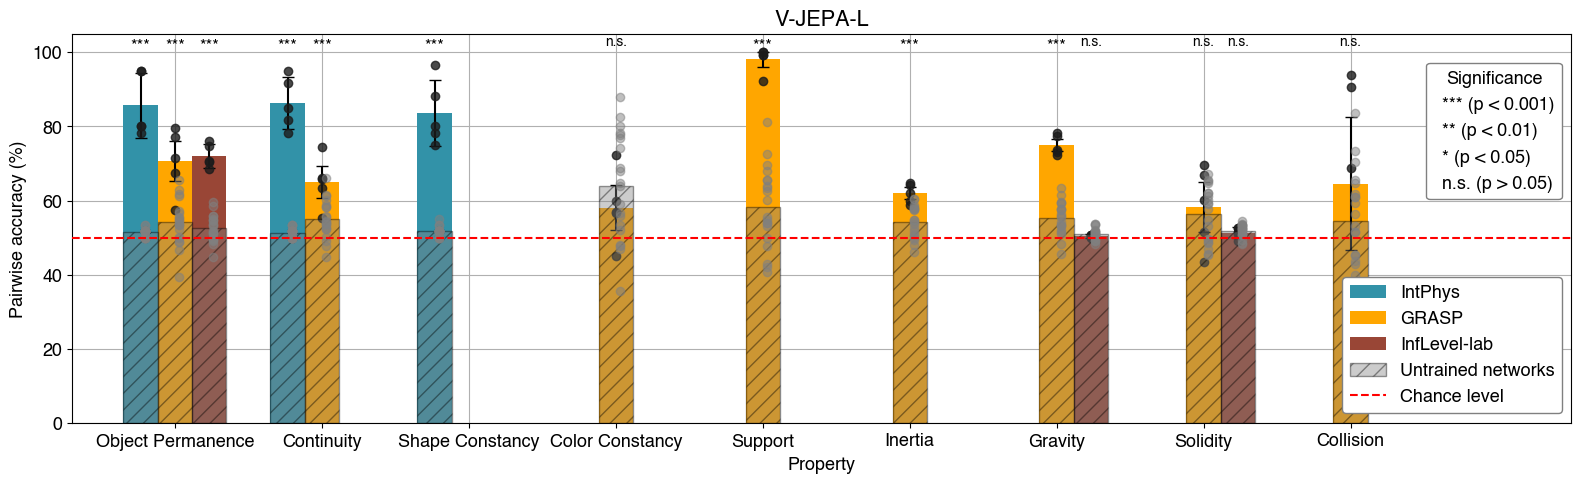

In [42]:
plt.figure(figsize=(20*0.8,6*0.8))
plot_all_accuracies(perfs_rand,perfs_large,categories,title="V-JEPA-L",do_bootstrap=False)
plt.savefig("./figures/results_per_cat_jepa_l.pdf",bbox_inches="tight")

/home/garridoq/.conda/envs/video/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/tmp/ipykernel_2260395/956036002.py:41: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  b = bootstrap((syn_preds,),np.mean)


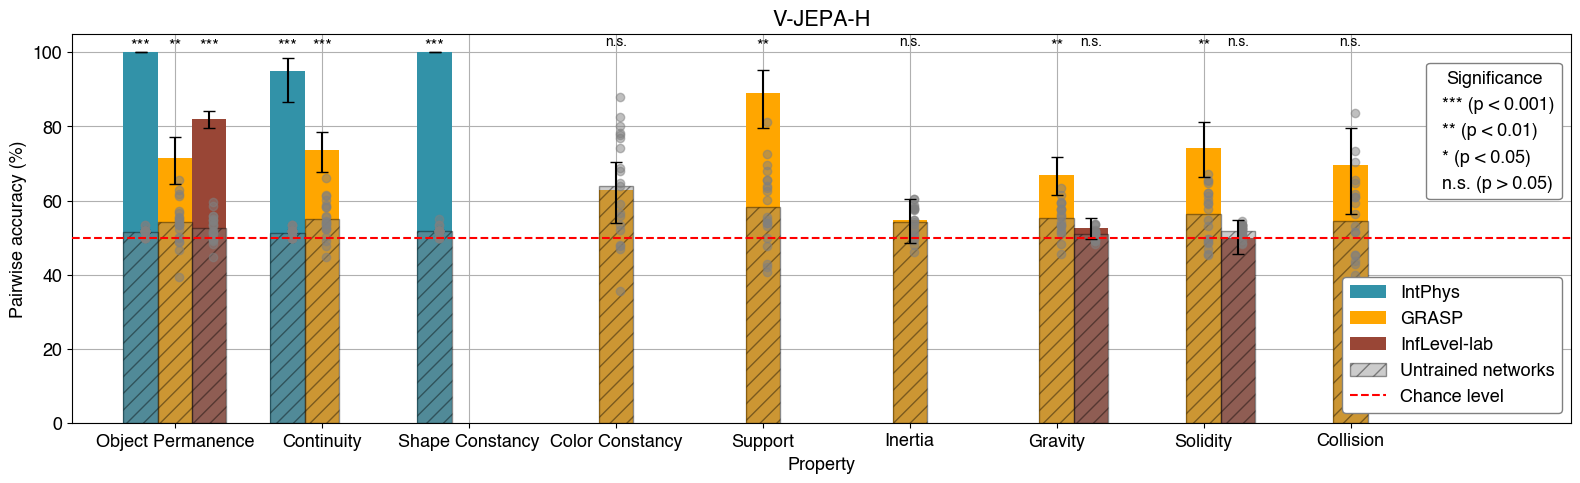

In [43]:

key_metric = "Relative Accuracy (avg)"
perfs = []
exp = "vit-h-rope-vm2m"
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
    perfs.append(perf_by_category)
    
plt.figure(figsize=(20*0.8,6*0.8))
plot_all_accuracies(perfs_rand,perfs,categories,title="V-JEPA-H")
plt.savefig("./figures/results_per_cat_jepa_h.pdf",bbox_inches="tight")

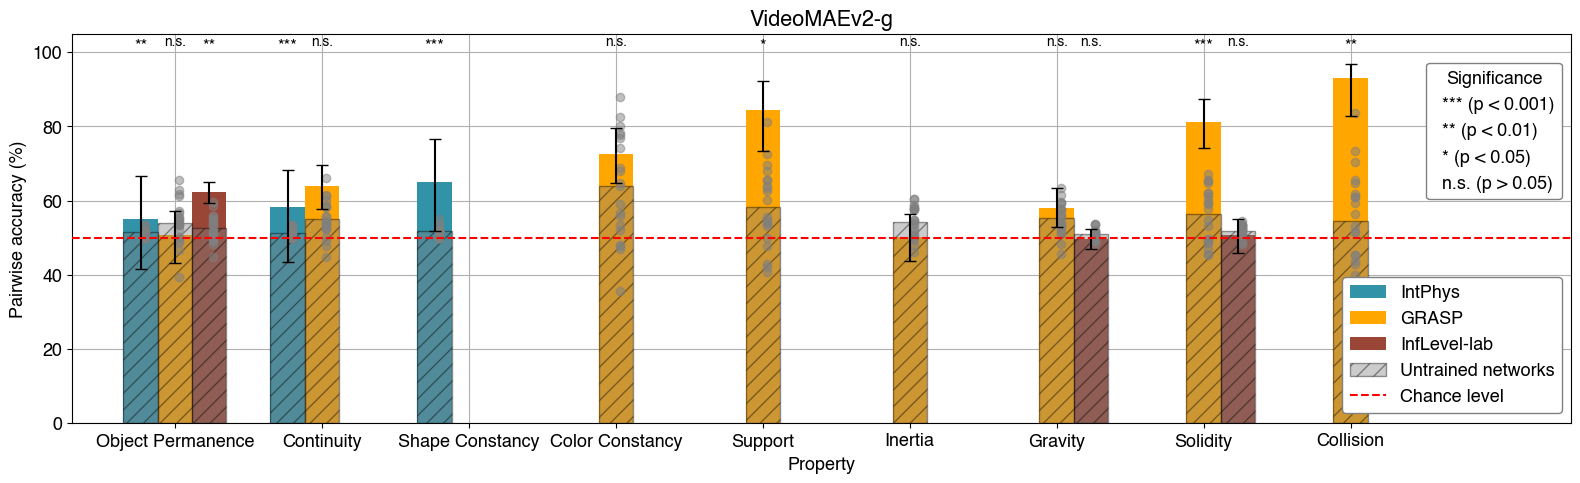

In [44]:
key_metric = "Relative Accuracy (avg)"
perfs = []
exp = "videomaev2_g"
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
    perfs.append(perf_by_category)

plt.figure(figsize=(20*0.8,6*0.8))
plot_all_accuracies(perfs_rand,perfs,categories,title="VideoMAEv2-g")
plt.savefig("./figures/results_per_cat_videmoae.pdf",bbox_inches="tight")

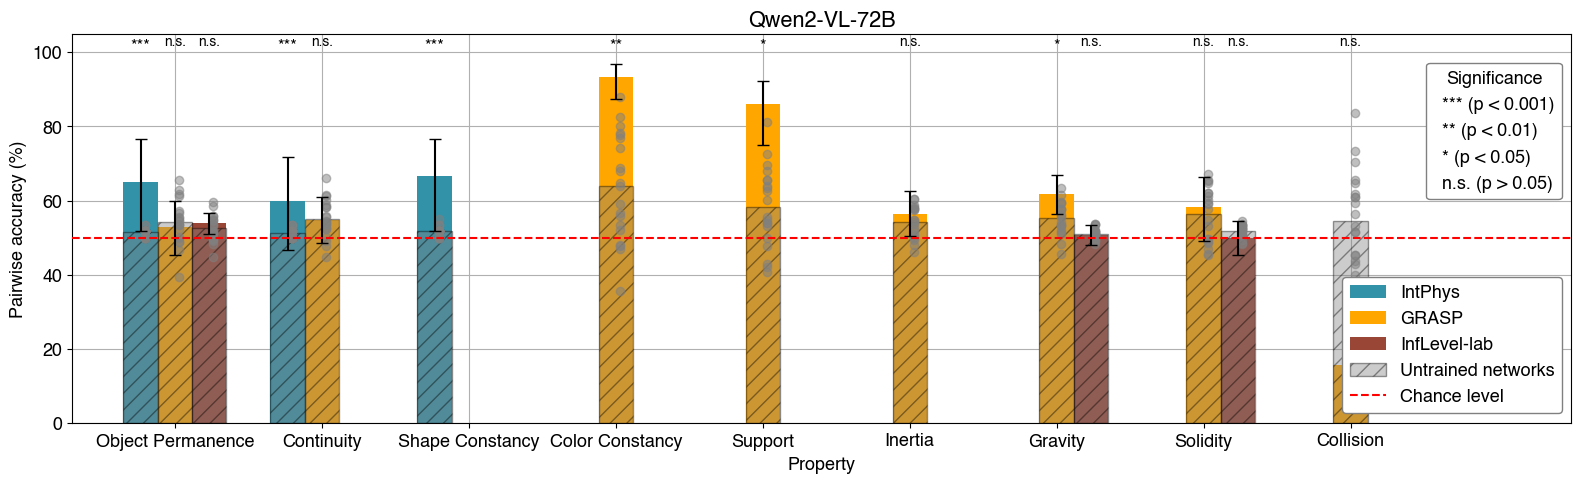

In [45]:
key_metric = "Relative Accuracy (avg)"
perfs = []
exp = "qwen2vl_72b"
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
    perfs.append(perf_by_category)

plt.figure(figsize=(20*0.8,6*0.8))
plot_all_accuracies(perfs_rand,perfs,categories,title="Qwen2-VL-72B")
plt.savefig("./figures/results_per_cat_qwen.pdf",bbox_inches="tight")

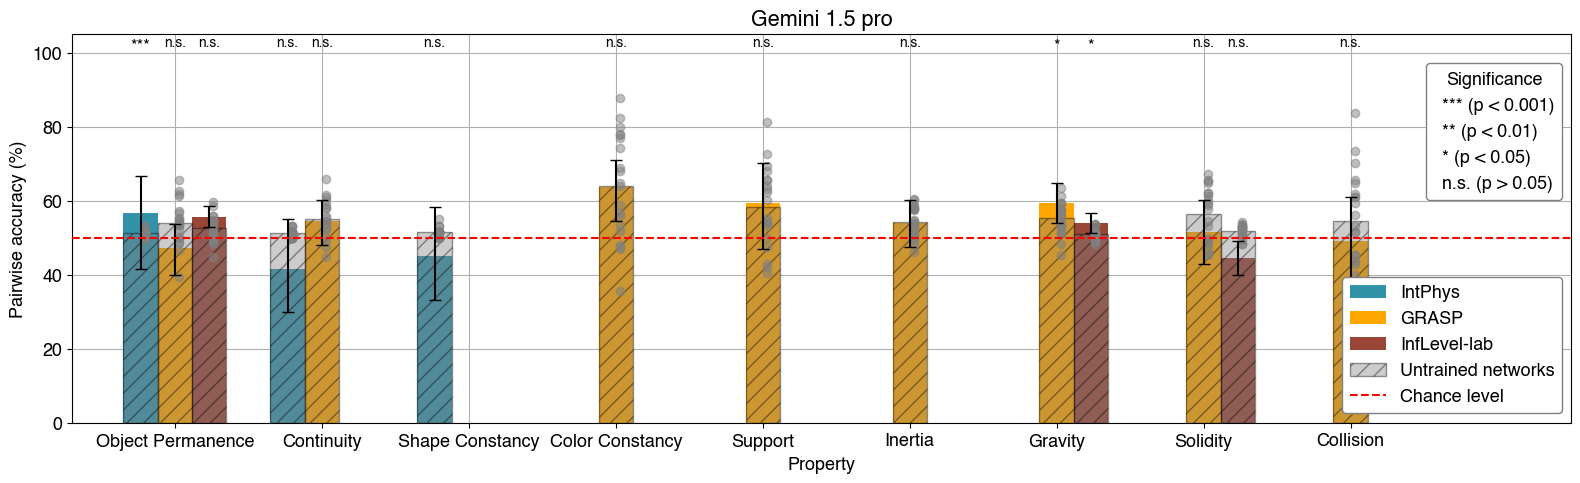

In [46]:
key_metric = "Relative Accuracy (avg)"
perfs = []
exp = "gemini_1.5_pro"
for dataset in ["intphys","grasp","inflevel"]:
    perf_by_category = get_perf(root,exp,dataset,key_metric=key_metric,categories=categories)
    perfs.append(perf_by_category)

plt.figure(figsize=(20*0.8,6*0.8))
plot_all_accuracies(perfs_rand,perfs,categories,title="Gemini 1.5 pro")
plt.savefig("./figures/results_per_cat_gemini.pdf",bbox_inches="tight")